### Stimulus decoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi
from mne.time_frequency import psd_array_multitaper
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from utils import *

from config import get_dates
from GDa.graphics import plot
from GDa.session import session
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, average_stages, create_stages_time_grid

In [3]:
def compute_pval(df_plot, stage, stim_label_1, stim_label_2):
    _, p = mannwhitneyu(
        df_plot.loc[
            (df_plot.times == stage) & (df_plot.trials == stim_label_1)
        ].power.values,
        df_plot.loc[
            (df_plot.times == stage) & (df_plot.trials == stim_label_2)
        ].power.values,
    )
    return p

In [4]:
avg = 1
tt = 1
br = 1
at = "cue"
monkey = "ethyl"
freq = 19

In [5]:
_ROOT = os.path.expanduser("~/funcog/gda")

In [24]:
def load_session_data(sid):

    # Instantiate class
    ses = session(
        raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
        monkey="lucy",
        date=sid,
        session=1,
        slvr_msmod=False,
        align_to="cue",
        evt_dt=[-0.65, 1.50],
    )

    # Read data from .mat files
    ses.read_from_mat()

    # Filtering by trials
    data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

    return data


def load_session_power(s_id, z_score=False, avg=0, roi=None):
    _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
    path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
    power = xr.load_dataarray(path_pow)
    if z_score:
        power.values = (power - power.mean("times")) / power.std("times")
    # Averages power for each period (baseline, cue, delay, match) if needed
    out = average_stages(power, avg)

    if isinstance(roi, str):
        out = out.sel(roi=roi)

    # out = out.sel(roi="V1")
    trials, stim = power.trials.data, power.stim

    return out, trials, stim


def load_session_pec_st(s_id, avg=0, roi=None):
    _FILE_NAME = f"pec_st_{s_id}_at_cue.nc"
    path_pec = os.path.join(_ROOT, f"Results/{monkey}/pec", _FILE_NAME)
    pec_st = xr.load_dataarray(path_pec)
    out = average_stages(pec_st, avg)

    if isinstance(roi, str):
        out = out.sel(roi=roi)

    return out


def load_session_coherence(s_id, z_score=False, avg=0, roi=None):
    _FILE_NAME = "coh_at_cue.nc"
    path_coh = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
    coh = temporal_network(
        coh_file=path_coh,
        coh_sig_file=None,
        wt=None,
        date=s_id,
        trial_type=[1],
        behavioral_response=[1],
    ).super_tensor

    if z_score:
        coh.values = (coh - coh.mean("times")) / coh.std("times")
    # Averages power for each period (baseline, cue, delay, match) if needed
    out = average_stages(coh, avg)

    if isinstance(roi, str):
        out = out.sel(roi=roi)

    trials, stim = coh.trials.data, coh.stim

    return out, trials, stim

In [25]:
sessions = get_dates(monkey)

#### Time-resolved rate

In [26]:
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

#### Power

In [27]:
path = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/power")
t_power = xr.load_dataarray(
    os.path.join(path, "tval_pow_1_br_1_aligned_cue_ds_1_avg_1_fdr.nc")
)
t_power = node_xr_remove_sca(t_power.sel(freqs=27))

In [28]:
P_b, SP_b = [], []
P_b_stim, SP_b_stim = [], []
RMI = []
dd = []
for s_id in tqdm(sessions):
    P_b += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "rate_modulations",
                f"P_b_{s_id}_tt_1_br_1_at_cue_ds_1_f_{freq}.nc",
            )
        )
    ]
    SP_b += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "rate_modulations",
                f"SP_b_{s_id}_tt_1_br_1_at_cue_ds_1_f_{freq}.nc",
            )
        )
    ]

    P_b_stim += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "rate_modulations",
                f"P_b_stim_{s_id}_tt_1_br_1_at_cue_ds_1_f_{freq}.nc",
            )
        )
    ]
    SP_b_stim += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "rate_modulations",
                f"SP_b_stim_{s_id}_tt_1_br_1_at_cue_ds_1_f_{freq}.nc",
            )
        )
    ]

    RMI += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "rate_modulations",
                f"RMI_{s_id}_tt_1_br_1_at_cue_ds_1_f_{freq}.nc",
            )
        )
    ]

    dd += [node_xr_remove_sca(load_session_pec_st(s_id, avg=1)).mean("trials")]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.88it/s]


In [29]:
P_b = node_xr_remove_sca(xr.concat(P_b, "roi").groupby("roi").mean("roi")).sel(
    roi=t_power.roi
)
P_b_stim = node_xr_remove_sca(
    xr.concat(P_b_stim, "roi").groupby("roi").mean("roi")
).sel(roi=t_power.roi)

SP_b = node_xr_remove_sca(xr.concat(SP_b, "roi").groupby("roi").mean("roi")).sel(
    roi=t_power.roi
)
SP_b_stim = node_xr_remove_sca(
    xr.concat(SP_b_stim, "roi").groupby("roi").mean("roi")
).sel(roi=t_power.roi)

RMI = node_xr_remove_sca(xr.concat(RMI, "roi").groupby("roi").mean("roi")).sel(
    roi=t_power.roi
)

dd = node_xr_remove_sca(xr.concat(dd, "roi").groupby("roi").mean("roi")).sel(
    roi=t_power.roi, freqs=27
)

In [30]:
X = P_b.median("boot")

In [31]:
labels = KMeans(n_clusters=4, random_state=10, init="random").fit(X.data).labels_

nmf = NMF(n_components=4, init="random", random_state=0, max_iter=1000)
W = nmf.fit_transform(X.data)
H = nmf.components_

X_embedded = umap.UMAP(n_neighbors=5, min_dist=1, random_state=20).fit_transform(W)

colors = ["r", "b", "g", "m"]

times = X.times.data.astype(np.float32)

In [32]:
idx = labels.argsort()

In [33]:
labels_dict = dict(zip(P_b.roi.data, labels))

In [34]:
l = []
for roi in t_power.roi.data:
    l += [labels_dict[roi]]

In [35]:
def plot_rate_probability(ax, vmax=0.05):
    plt.sca(ax)
    plt.imshow(
        X[idx, :], aspect="auto", cmap="turbo", origin="lower", vmin=0, vmax=vmax
    )
    cbar = plt.colorbar(extend="max")
    cbar.ax.set_ylabel(r"$P_t[B]$", rotation=90, fontsize=10)
    x_ticks_idx = ax.get_xticks()[1:-1].astype(int)
    plt.xticks(x_ticks_idx, times[x_ticks_idx])
    tks = plt.yticks(range(P_b.sizes["roi"]), P_b.roi.data[idx])
    [tks[1][i].set_color(colors[labels[idx][i]]) for i in range(P_b.sizes["roi"])]
    plt.xlabel("Time [s]", fontsize=12)
    ax.axvline(np.abs(0 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--")
    ax.axvline(
        np.abs(0.5 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
    )
    ax.axvline(
        np.abs(1.5 - times).argmin(), -0.1, X.sizes["roi"] - 1, color="k", ls="--"
    )


def plot_embedding(ax, names=True):
    plt.sca(ax)
    for i in range(len(X_embedded)):
        plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[labels[i]])
    if names:
        for i in range(len(X_embedded)):
            plt.text(X_embedded[i, 0] + 0.1, X_embedded[i, 1] + 0.1, X.roi.data[i])
    plt.xticks([])
    plt.yticks([])
    [ax.spines[key].set_visible(False) for key in ax.spines.keys()]


def plot_cc_tpower(ax, j):
    plt.sca(ax)
    colors = ["r", "b", "g", "m"]
    stage = ["S", "D1", "D2", "M"]
    dd_plot = dd.sel(roi=t_power.roi.data)

    for i, roi in enumerate(t_power.roi.data):
        plt.scatter(
            dd_plot.isel(roi=i, times=j), t_power.isel(roi=i, times=j), c=colors[l[i]]
        )
        if dd_plot.roi.data[i] == "V1":
            plt.text(
                dd_plot.isel(roi=i, times=j) + 0.1,
                t_power.isel(roi=i, times=j) + 0.1,
                dd_plot.roi.data[i],
            )
        elif dd_plot.roi.data[i] == "V2":
            plt.text(
                dd_plot.isel(roi=i, times=j) + 0.1,
                t_power.isel(roi=i, times=j) + 0.1,
                dd_plot.roi.data[i],
            )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.xlabel("CC strength")
    plt.ylabel("t-power")
    plt.title(f"{stage[j - 1]}")


def plot_rmi_tpow(ax, j, y):
    stage = ["S", "D1", "D2", "M"]
    for i in range(dd.sizes["roi"]):
        plt.scatter(
            RMI.isel(roi=i),
            y.sel(times=j).isel(roi=i),
            c=colors[l[i]],
        )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"{stage[j]}")


"""
def plot_rate(ax, label, color):
    plt.sca(ax)
    idx = labels == label
    rate = P_b.isel(roi=idx).mean("roi")
    surr_rate = (
        P_b.isel(roi=idx).sel(times=slice(-0.45, -0.1)).mean("roi")
    )  
    plt.step(P_b.times, np.quantile(rate, 0.5, 0), color=color)
    plt.fill_between(
        P_b.times,
        np.quantile(rate, 0.05, axis=0),
        np.quantile(rate, 0.95, axis=0),
        color=color,
        step="pre",
        alpha=0.2,
    )

    plt.fill_between(
        P_b.times,
        surr_rate.quantile(0.05, ("boot", "times")),
        surr_rate.quantile(0.95, ("boot", "times")),
        color="lightgray",
        alpha=0.6,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel(r"$P_t[B]$")
    plt.xlabel("Time [s]")
"""


def plot_rate(ax, label, color):
    plt.sca(ax)
    idx = labels == label
    rate = (W[idx] @ H).mean(0)
    surr_rate = P_b.isel(roi=idx).sel(times=slice(-0.45, -0.1)).mean("roi")
    plt.plot(P_b.times, rate, color=color)
    plt.fill_between(
        P_b.times,
        surr_rate.quantile(0.05, ("boot", "times")),
        surr_rate.quantile(0.95, ("boot", "times")),
        color="lightgray",
        alpha=0.6,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel(r"$P_t[B]$")
    plt.xlabel("Time [s]")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel(r"$P_t[B]$")
    plt.xlabel("Time [s]")

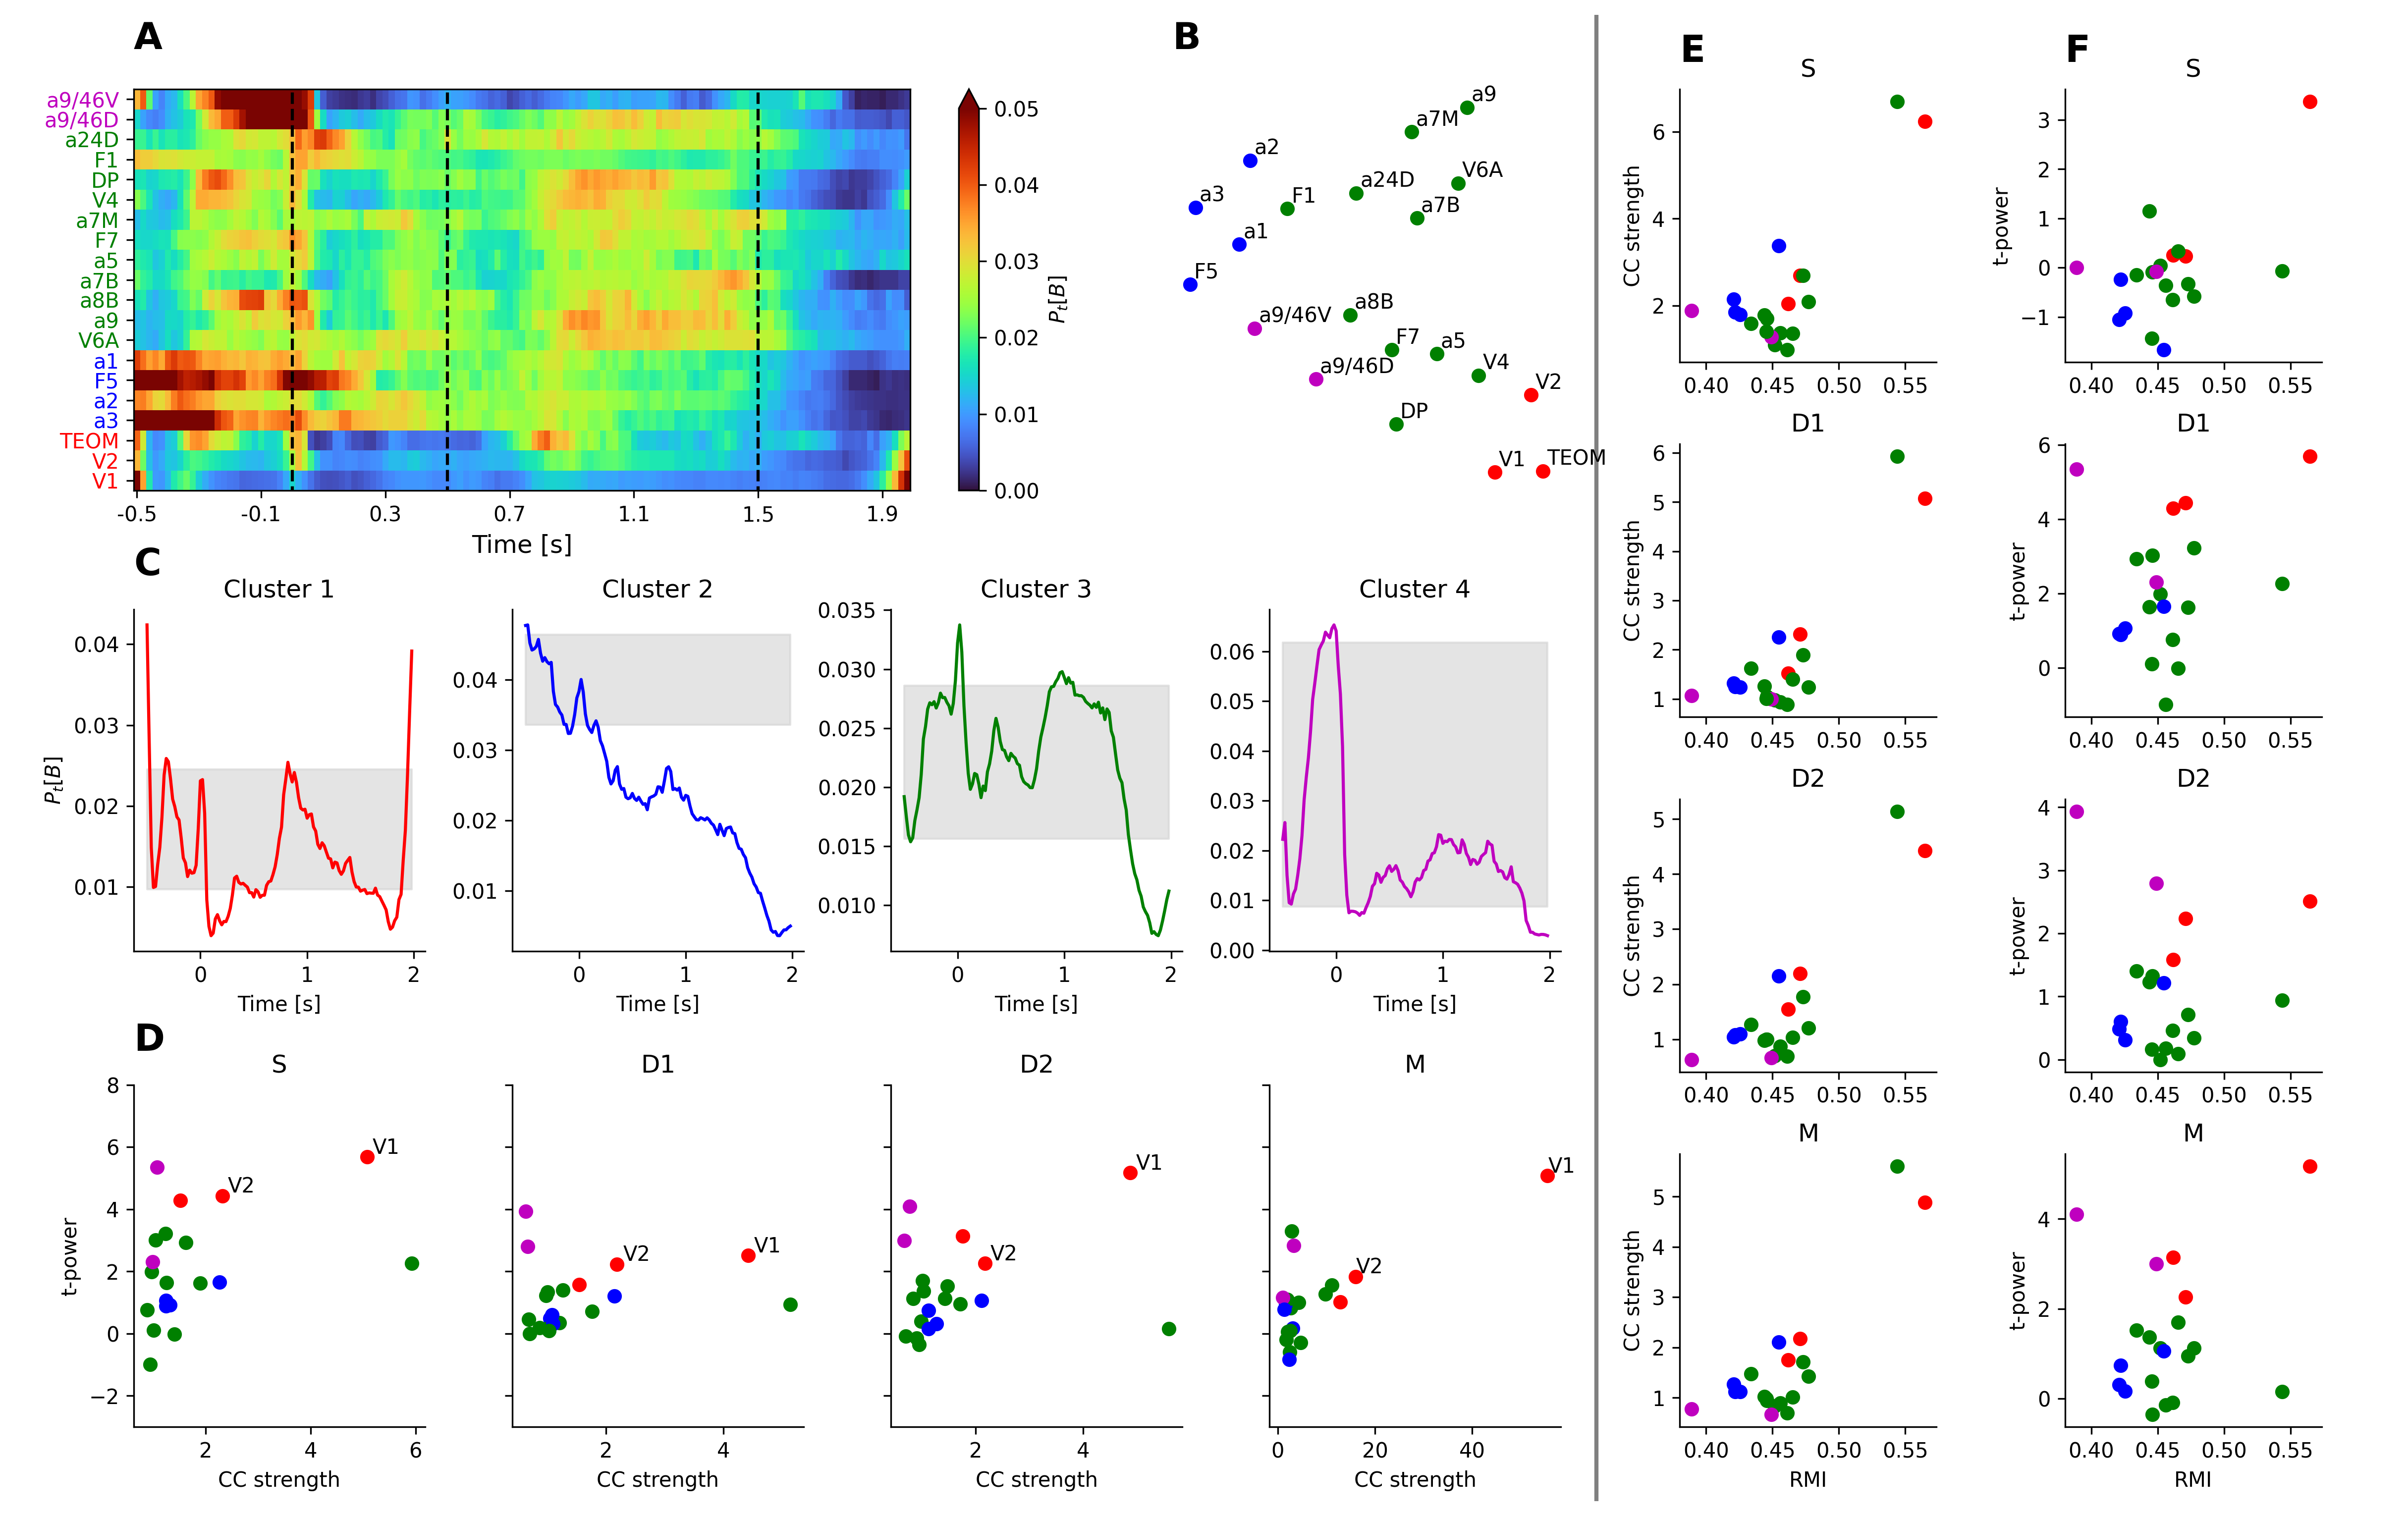

In [36]:
fig = plt.figure(figsize=(16, 10), dpi=300)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.05,
    right=0.65,
    wspace=0.1,
    bottom=0.68,
    top=0.95,
    width_ratios=(1.0, 0.4),
)

gs1 = fig.add_gridspec(
    nrows=1, ncols=4, left=0.05, right=0.65, wspace=0.3, bottom=0.37, top=0.6
)

gs2 = fig.add_gridspec(
    nrows=1, ncols=4, left=0.05, right=0.65, wspace=0.3, bottom=0.05, top=0.28
)

gs3 = fig.add_gridspec(
    nrows=4,
    ncols=2,
    left=0.70,
    right=0.97,
    wspace=0.5,
    hspace=0.3,
    bottom=0.05,
    top=0.95,
)

# Panel A
ax1 = plt.subplot(gs0[0])
plot_rate_probability(ax1)

ax2 = plt.subplot(gs0[1])
plot_embedding(ax2)

# Panel B
ax3 = plt.subplot(gs1[0])
plot_rate(ax3, 0, colors[0])
plt.title("Cluster 1")
ax4 = plt.subplot(gs1[1])
plot_rate(ax4, 1, colors[1])
plt.title("Cluster 2")
plt.ylabel("")
ax5 = plt.subplot(gs1[2])
plot_rate(ax5, 2, colors[2])
plt.title("Cluster 3")
plt.ylabel("")
ax6 = plt.subplot(gs1[3])
plot_rate(ax6, 3, colors[3])
plt.title("Cluster 4")
plt.ylabel("")


# Panel C
ax7 = plt.subplot(gs2[0])
plot_cc_tpower(ax7, 1)
plt.ylim(-3, 8)
ax8 = plt.subplot(gs2[1])
plot_cc_tpower(ax8, 2)
plt.ylabel("")
plt.ylim(-3, 8)
ax8.axes.yaxis.set_ticklabels([])
ax9 = plt.subplot(gs2[2])
plot_cc_tpower(ax9, 3)
plt.ylabel("")
plt.ylim(-3, 8)
ax9.axes.yaxis.set_ticklabels([])
ax10 = plt.subplot(gs2[3])
plot_cc_tpower(ax10, 4)
plt.ylabel("")
plt.ylim(-3, 8)
ax10.axes.yaxis.set_ticklabels([])

# Panel D
ax11 = plt.subplot(gs3[0])
plot_rmi_tpow(ax11, 0, dd)
plt.xlabel("")
plt.ylabel("CC strength")
ax12 = plt.subplot(gs3[1])
plot_rmi_tpow(ax12, 0, t_power)
plt.xlabel("")
plt.ylabel("t-power")
ax13 = plt.subplot(gs3[2])
plot_rmi_tpow(ax13, 1, dd)
plt.xlabel("")
plt.ylabel("CC strength")
ax14 = plt.subplot(gs3[3])
plot_rmi_tpow(ax14, 1, t_power)
plt.xlabel("")
plt.ylabel("t-power")
ax15 = plt.subplot(gs3[4])
plot_rmi_tpow(ax15, 2, dd)
plt.xlabel("")
plt.ylabel("CC strength")
ax16 = plt.subplot(gs3[5])
plot_rmi_tpow(ax16, 2, t_power)
plt.xlabel("")
plt.ylabel("t-power")
ax17 = plt.subplot(gs3[6])
plot_rmi_tpow(ax17, 3, dd)
plt.ylabel("CC strength")
plt.xlabel("RMI")
ax18 = plt.subplot(gs3[7])
plot_rmi_tpow(ax18, 3, t_power)
plt.ylabel("t-power")
plt.xlabel("RMI")

plot.add_panel_letters(
    fig,
    axes=[ax1, ax2, ax3, ax7, ax11, ax12],
    fontsize=18,
    xpos=[0] * 6,
    ypos=[1.1] * 6,
)

bg = plot.Background(visible=False)
bg.vline(0.665, lw=2)
plt.savefig(f"img/panel_rates_{monkey}.png")

In [19]:
H = xr.DataArray(H, dims=("cluster", "times"), coords={"times": P_b.times})
W = xr.DataArray(W, dims=("roi", "cluster"), coords={"roi": P_b.roi})

In [20]:
def remove_top_right(ax):

    [ax.spines[key].set_visible(False) for key in ["top", "right"]]


def plot_loadings(ax, cbar_ax, cluster, cbar_title=None):
    plt.sca(ax)
    values = W.sel(cluster=cluster)
    areas = [a.lower() for a in values.roi.data]
    fmap = flatmap(values.data, areas)
    fmap.plot(
        ax,
        ax_colorbar=cbar_ax,
        cbar_title=cbar_title,
        vmin=0,
        vmax=0.2,
        alpha=0.6,
        colormap="Greys",
    )

In [21]:
from GDa.flatmap.flatmap import flatmap

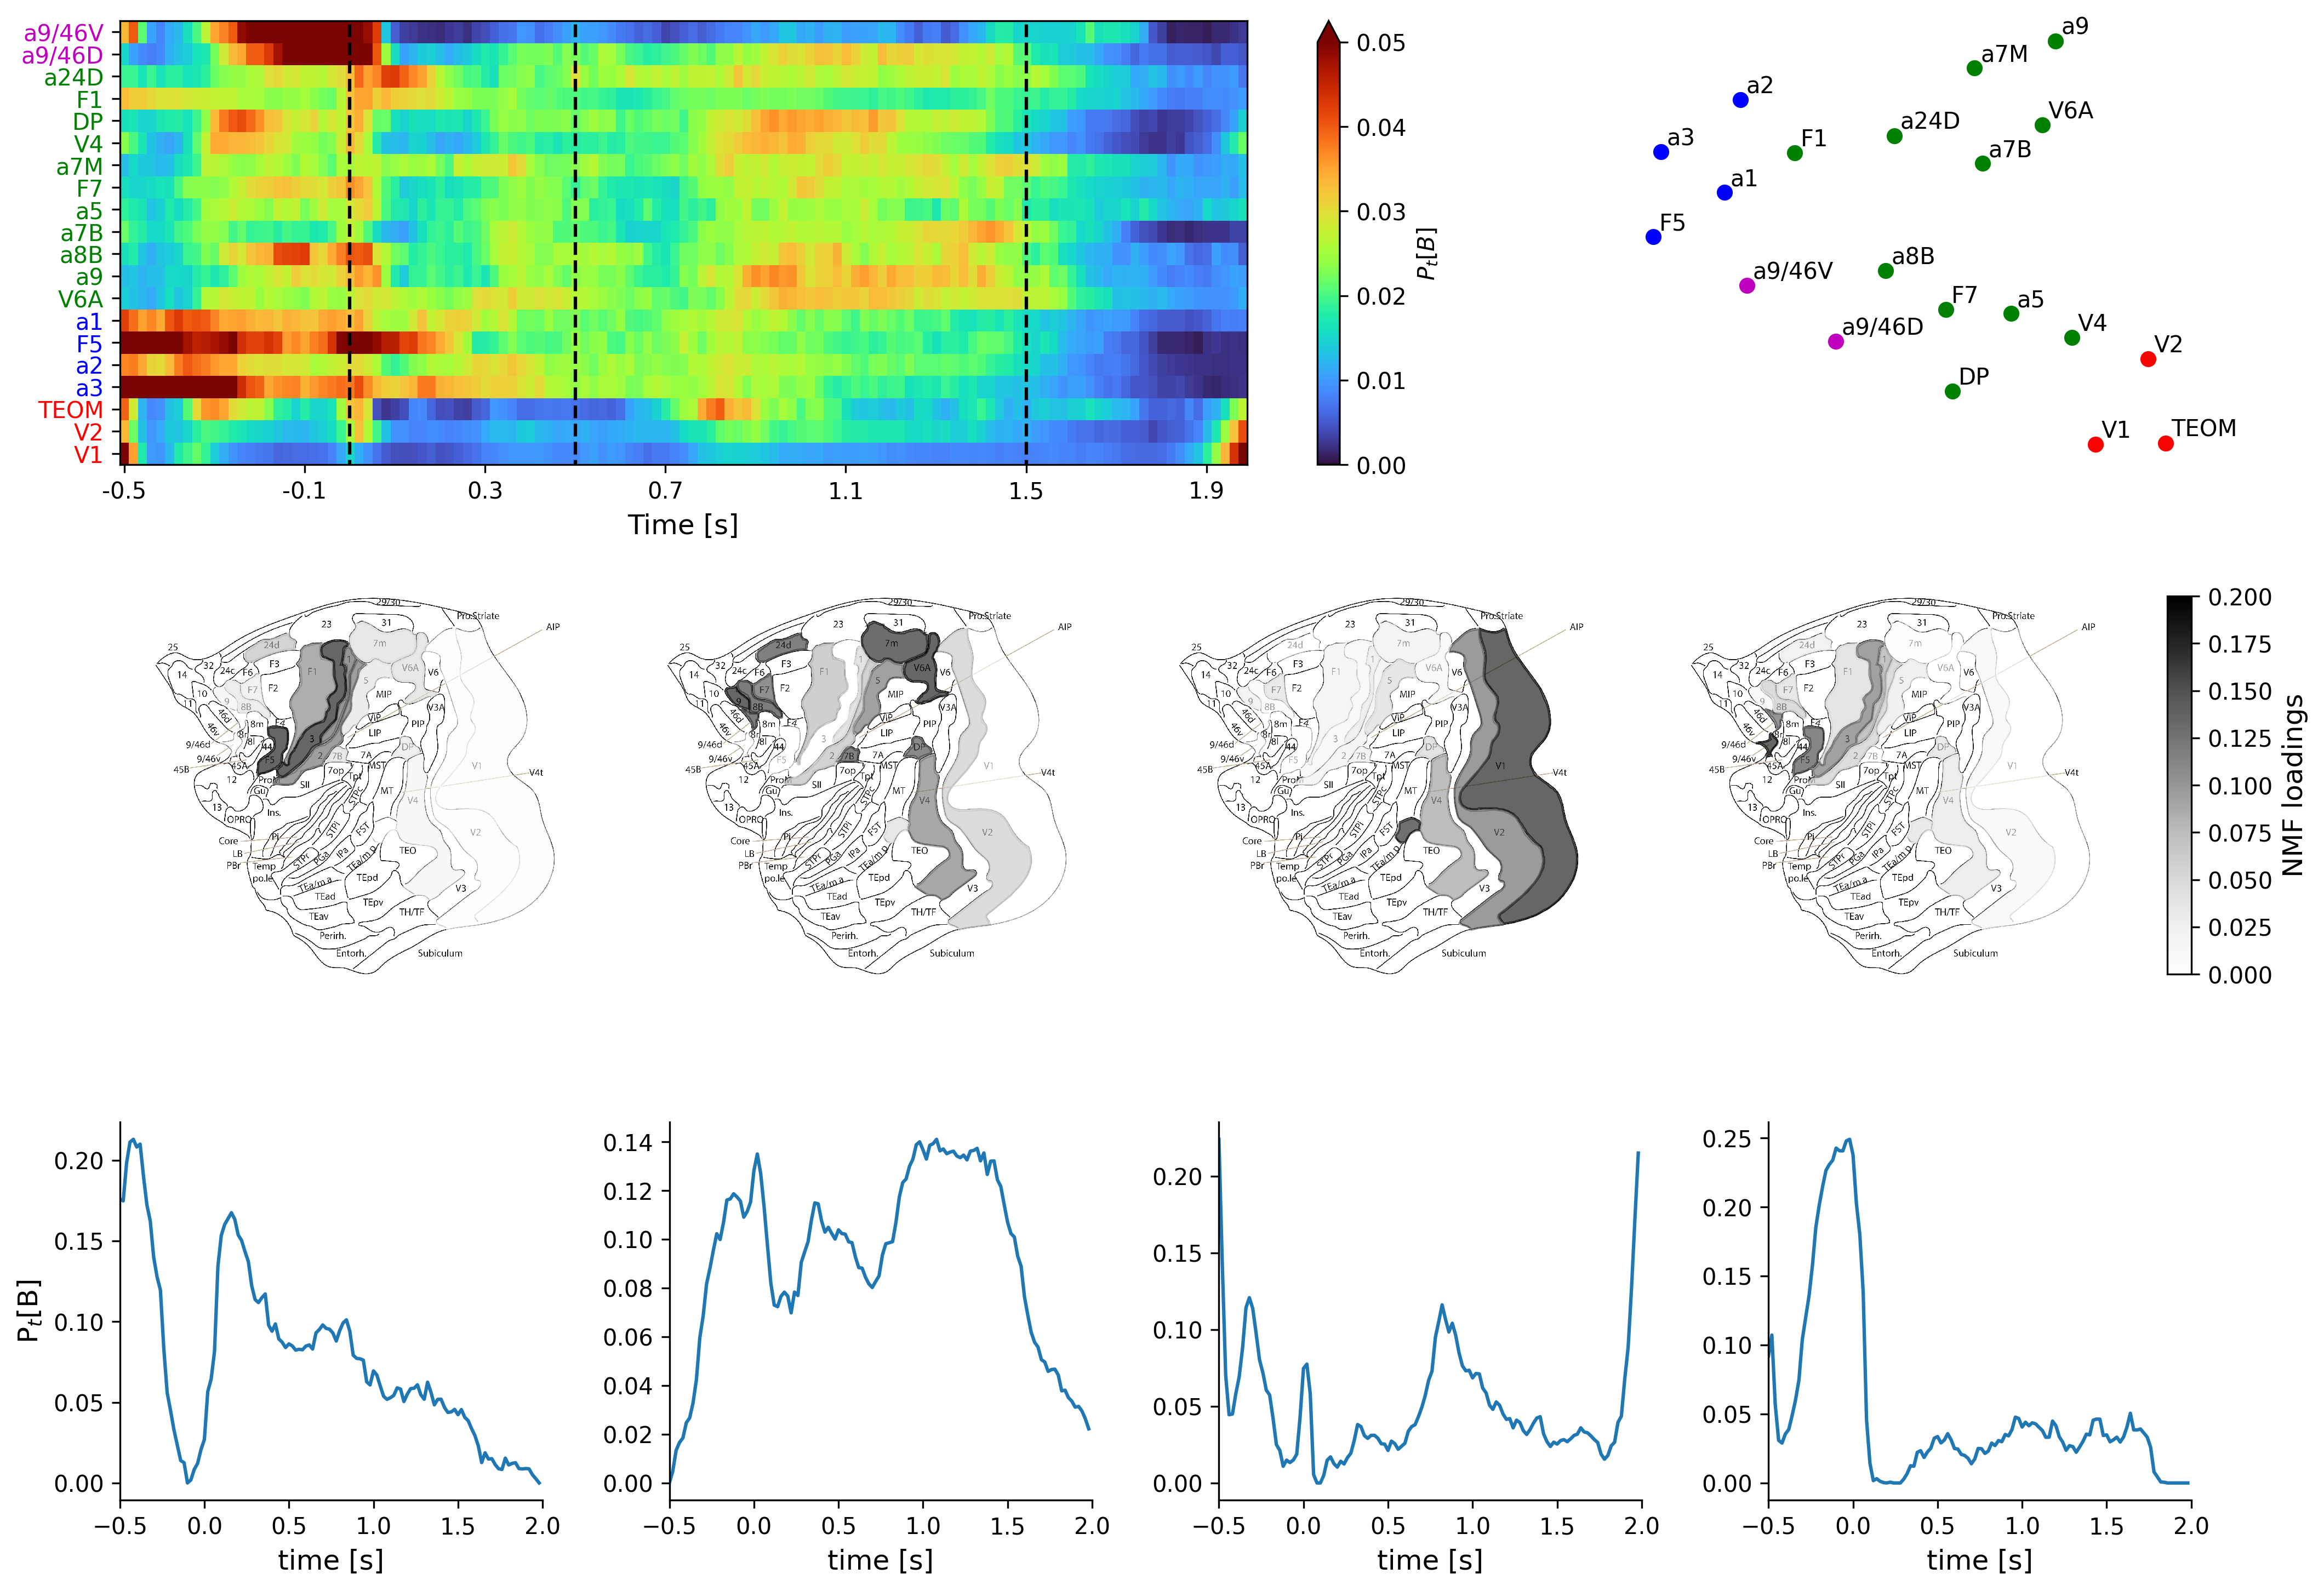

In [22]:
fig = plt.figure(figsize=(14, 10), dpi=300)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.05,
    right=0.95,
    wspace=0.1,
    bottom=0.68,
    top=0.95,
    width_ratios=(1.0, 0.4),
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=5,
    left=0.05,
    right=0.95,
    wspace=0.1,
    bottom=0.37,
    top=0.6,
    width_ratios=(1.0, 1.0, 1.0, 1.0, 0.05),
)

gs2 = fig.add_gridspec(
    nrows=1, ncols=4, left=0.05, right=0.95, wspace=0.3, bottom=0.05, top=0.28
)

# Panel A
ax1 = plt.subplot(gs0[0])
plot_rate_probability(ax1)

ax2 = plt.subplot(gs0[1])
plot_embedding(ax2)

ax3 = plt.subplot(gs1[0])
plot_loadings(ax3, None, 0)

ax4 = plt.subplot(gs1[1])
plot_loadings(ax4, None, 1)

ax5 = plt.subplot(gs1[2])
plot_loadings(ax5, None, 2)

ax6 = plt.subplot(gs1[3])
ax7 = plt.subplot(gs1[4])

plot_loadings(ax6, ax7, 3, "NMF loadings")

ax7 = plt.subplot(gs2[0])
plt.plot(P_b.times, H[0])
plt.ylabel(r"P$_t$[B]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)
plt.xlim(-0.5, 2)
remove_top_right(ax7)
ax8 = plt.subplot(gs2[1])
plt.plot(P_b.times, H[1])
plt.xlabel("time [s]", fontsize=12)
plt.xlim(-0.5, 2)
remove_top_right(ax8)
ax9 = plt.subplot(gs2[2])
plt.plot(P_b.times, H[2])
plt.xlabel("time [s]", fontsize=12)
plt.xlim(-0.5, 2)
remove_top_right(ax9)
ax10 = plt.subplot(gs2[3])
plt.plot(P_b.times, H[3])
plt.xlabel("time [s]", fontsize=12)
plt.xlim(-0.5, 2)
remove_top_right(ax10)

plt.savefig(f"img/nmf_rates_{monkey}.png")

#### Coherence

In [47]:
path = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/coherence")
t_coh = xr.load_dataarray(os.path.join(path, "tval_coh_at_cue_ds_1_avg_1_fdr.nc"))
t_coh = xr_remove_same_roi(edge_xr_remove_sca(t_coh.sel(freqs=27)))

In [48]:
P_b, SP_b = [], []
P_b_stim, SP_b_stim = [], []
RMI = []
for s_id in tqdm(sessions[:50]):
    P_b += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "coh_rate_modulations",
                f"P_b_{s_id}_at_cue_ds_1.nc",
            )
        )
    ]
    SP_b += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "coh_rate_modulations",
                f"SP_b_{s_id}_at_cue_ds_1.nc",
            )
        )
    ]

    P_b_stim += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "coh_rate_modulations",
                f"P_b_stim_{s_id}_at_cue_ds_1.nc",
            )
        )
    ]
    SP_b_stim += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "coh_rate_modulations",
                f"SP_b_stim_{s_id}_at_cue_ds_1.nc",
            )
        )
    ]

    RMI += [
        xr.load_dataarray(
            os.path.join(
                _ROOT,
                "Results",
                monkey,
                "coh_rate_modulations",
                f"RMI_{s_id}_at_cue_ds_1.nc",
            )
        )
    ]

100%|████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.61it/s]


In [49]:
P_b = xr_remove_same_roi(
    edge_xr_remove_sca(xr.concat(P_b, "roi").groupby("roi").mean("roi"))
)

P_b_stim = xr_remove_same_roi(
    edge_xr_remove_sca(xr.concat(P_b_stim, "roi").groupby("roi").mean("roi"))
)

SP_b = xr_remove_same_roi(
    edge_xr_remove_sca(xr.concat(SP_b, "roi").groupby("roi").mean("roi"))
)

SP_b_stim = xr_remove_same_roi(
    edge_xr_remove_sca(xr.concat(SP_b_stim, "roi").groupby("roi").mean("roi"))
)

RMI = xr_remove_same_roi(
    edge_xr_remove_sca(xr.concat(RMI, "roi").groupby("roi").mean("roi"))
)

In [50]:
rois = [r for r in t_coh.roi.data if r in P_b.roi.data]

In [51]:
P_b = P_b.sel(roi=rois)
SP_b = SP_b.sel(roi=rois)
P_b_stim = P_b_stim.sel(roi=rois)
SP_b_stim = SP_b_stim.sel(roi=rois)
RMI = RMI.sel(roi=rois)

In [52]:
t_coh_rois = t_coh.sel(roi=rois)

In [53]:
path_ent = os.path.expanduser("~/funcog/gda/Results/lucy/meta_conn")
ent = xr.load_dataarray(os.path.join(path_ent, "ent_coh_141017_at_cue_ds_1_thr_0.nc"))

In [54]:
path_to_mc = f"/home/vinicius/funcog/gda/Results/{monkey}/meta_conn/"

ent = []

for session in tqdm(sessions):

    ent += [
        xr.load_dataarray(
            os.path.join(path_to_mc, f"ent_coh_{session}_at_cue_ds_{1}_thr_0.nc")
        )
    ]

ent = xr.concat(ent, "roi").groupby("roi").mean("roi")
ent = ent.sel(roi=rois, freqs=27)

100%|████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.03it/s]


In [55]:
X = P_b.median("boot")

In [56]:
# Number of clusters to use
n_clusters = np.arange(2, 21, 1, dtype=int)
# Silhouette score
se = np.zeros_like(n_clusters, dtype=float)
for i, nc in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(X.data)
    se[i] = silhouette_score(X, kmeans.labels_, metric="euclidean")

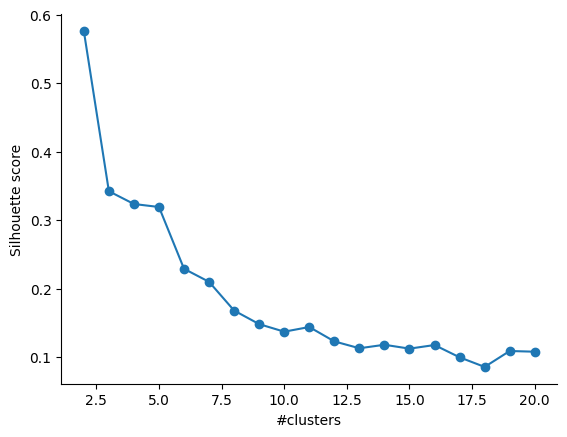

In [57]:
ax = plt.subplot(111)
plt.plot(n_clusters, se, "o-")
plt.ylabel("Silhouette score")
plt.xlabel("#clusters")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [58]:
X_embedded = umap.UMAP(n_neighbors=5, min_dist=1, random_state=20).fit_transform(X.data)

labels = kmeans = KMeans(n_clusters=4, random_state=0).fit(X.data).labels_

colors = ["r", "b", "g", "m"]

times = X.times.data.astype(np.float32)

In [59]:
labels_dict = dict(zip(P_b.roi.data, labels))

l = []
for roi in rois:
    l += [labels_dict[roi]]

In [60]:
idx = labels.argsort()

In [61]:
unique_rois = np.unique(np.hstack(_extract_roi(P_b.roi.data, "-")))
incidence = xr.DataArray(
    np.zeros((len(unique_rois), labels.max() + 1)),
    dims=("roi", "cluster"),
    coords={"roi": unique_rois},
)

for i in range(labels.max() + 1):
    unique_rois_label, counts = np.unique(
        np.hstack(_extract_roi(P_b.roi.data[labels == i], "-")), return_counts=True
    )
    for j, roi in enumerate(unique_rois_label):
        if roi in incidence.roi.data:
            incidence[j, i] = counts[j]
data = incidence / incidence.sum("cluster")

In [62]:
"""
early_cue = 0.2
early_delay = 0.3
s_mask = create_stages_time_grid(
    out.t_cue_on - early_cue * out.fsample,
    out.t_cue_off,
    out.t_match_on,
    out.fsample,
    out.times.data,
    out.sizes["trials"],
    early_delay=early_delay,
    align_to="cue",
    flatten=False,
)

n_samp = []
for key in s_mask.keys():
    n_samp += [s_mask[key].sum()]

bst = tensor_burstness_stats(
    np.transpose((out.sel(freqs=27).data >= 3), (1, 0, 2)),
    s_mask,
    drop_edges=True,
    find_zeros=True,
    samples=n_samp,
    dt=np.diff(out.times)[0],
)

bst = xr.DataArray(
    bst[..., -1], dims=("roi", "times"), coords={"roi": out.roi}, name="bst"
)
""";

In [63]:
def plot_ent_tcoh(ax, j):
    plt.sca(ax)
    colors = ["r", "b", "g", "m"]
    stage = ["S", "D1", "D2", "M"]
    idx = np.logical_or(labels == 1, labels == 3)
    l_ = np.asarray(l)[idx]
    ent_ = ent.isel(roi=idx)
    t_coh_rois_ = t_coh_rois.isel(roi=idx)
    for i in range(ent_.sizes["roi"]):
        plt.scatter(
            ent_.isel(roi=i, times=j), t_coh_rois_.isel(roi=i, times=j), c=colors[l_[i]]
        )
        if ent.roi.data[i] == "F1-V1":
            plt.text(
                ent_.isel(roi=i, times=j) + 0.1,
                t_coh_rois_.isel(roi=i, times=j) + 0.1,
                ent_.roi.data[i],
            )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.xlabel("Entanglement")
    plt.ylabel("t-coh")
    plt.title(f"{stage[j - 1]}")


def plot_rate(ax, label, color):
    plt.sca(ax)
    idx = labels == label
    rate = P_b.isel(roi=idx).mean("roi")
    surr_rate = (
        P_b.isel(roi=idx).sel(times=slice(-0.45, -0.1)).mean("roi")
    )  # SP_b.isel(roi=idx).mean("roi")
    plt.step(P_b.times, np.quantile(rate, 0.5, 0), color=color)
    plt.fill_between(
        P_b.times,
        np.quantile(rate, 0.05, axis=0),
        np.quantile(rate, 0.95, axis=0),
        color=color,
        step="pre",
        alpha=0.2,
    )

    plt.fill_between(
        P_b.times,
        surr_rate.quantile(0.05, ("boot", "times")),
        surr_rate.quantile(0.95, ("boot", "times")),
        color="lightgray",
        alpha=0.6,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel(r"$P_t[B]$")
    plt.xlabel("Time [s]")


def plot_rmi_tcoh(ax, j, y):
    stage = ["S", "D1", "D2", "M"]
    idx = np.logical_or(labels == 1, labels == 3)
    l_ = np.asarray(l)[idx]
    ent_ = ent.isel(roi=idx)
    RMI_ = RMI.isel(roi=idx)
    y_ = y.isel(roi=idx)

    for i in range(ent_.sizes["roi"]):
        plt.scatter(
            RMI_.isel(roi=i),
            y_.sel(times=j).isel(roi=i),
            c=colors[l_[i]],
        )
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]


def plot_bursting(label):
    bst_ = xr.concat([bst.sel(roi=r) for r in P_b.roi[labels == label].data], "roi")
    ax = sns.violinplot(
        data=bst_.to_dataframe().reset_index(),
        x="times",
        y="bst",
        color=colors[label],
        showfliers=False,
        inner="box",
        scale="count",
        trim=True,
    )
    plt.setp(ax.collections, alpha=0.6)

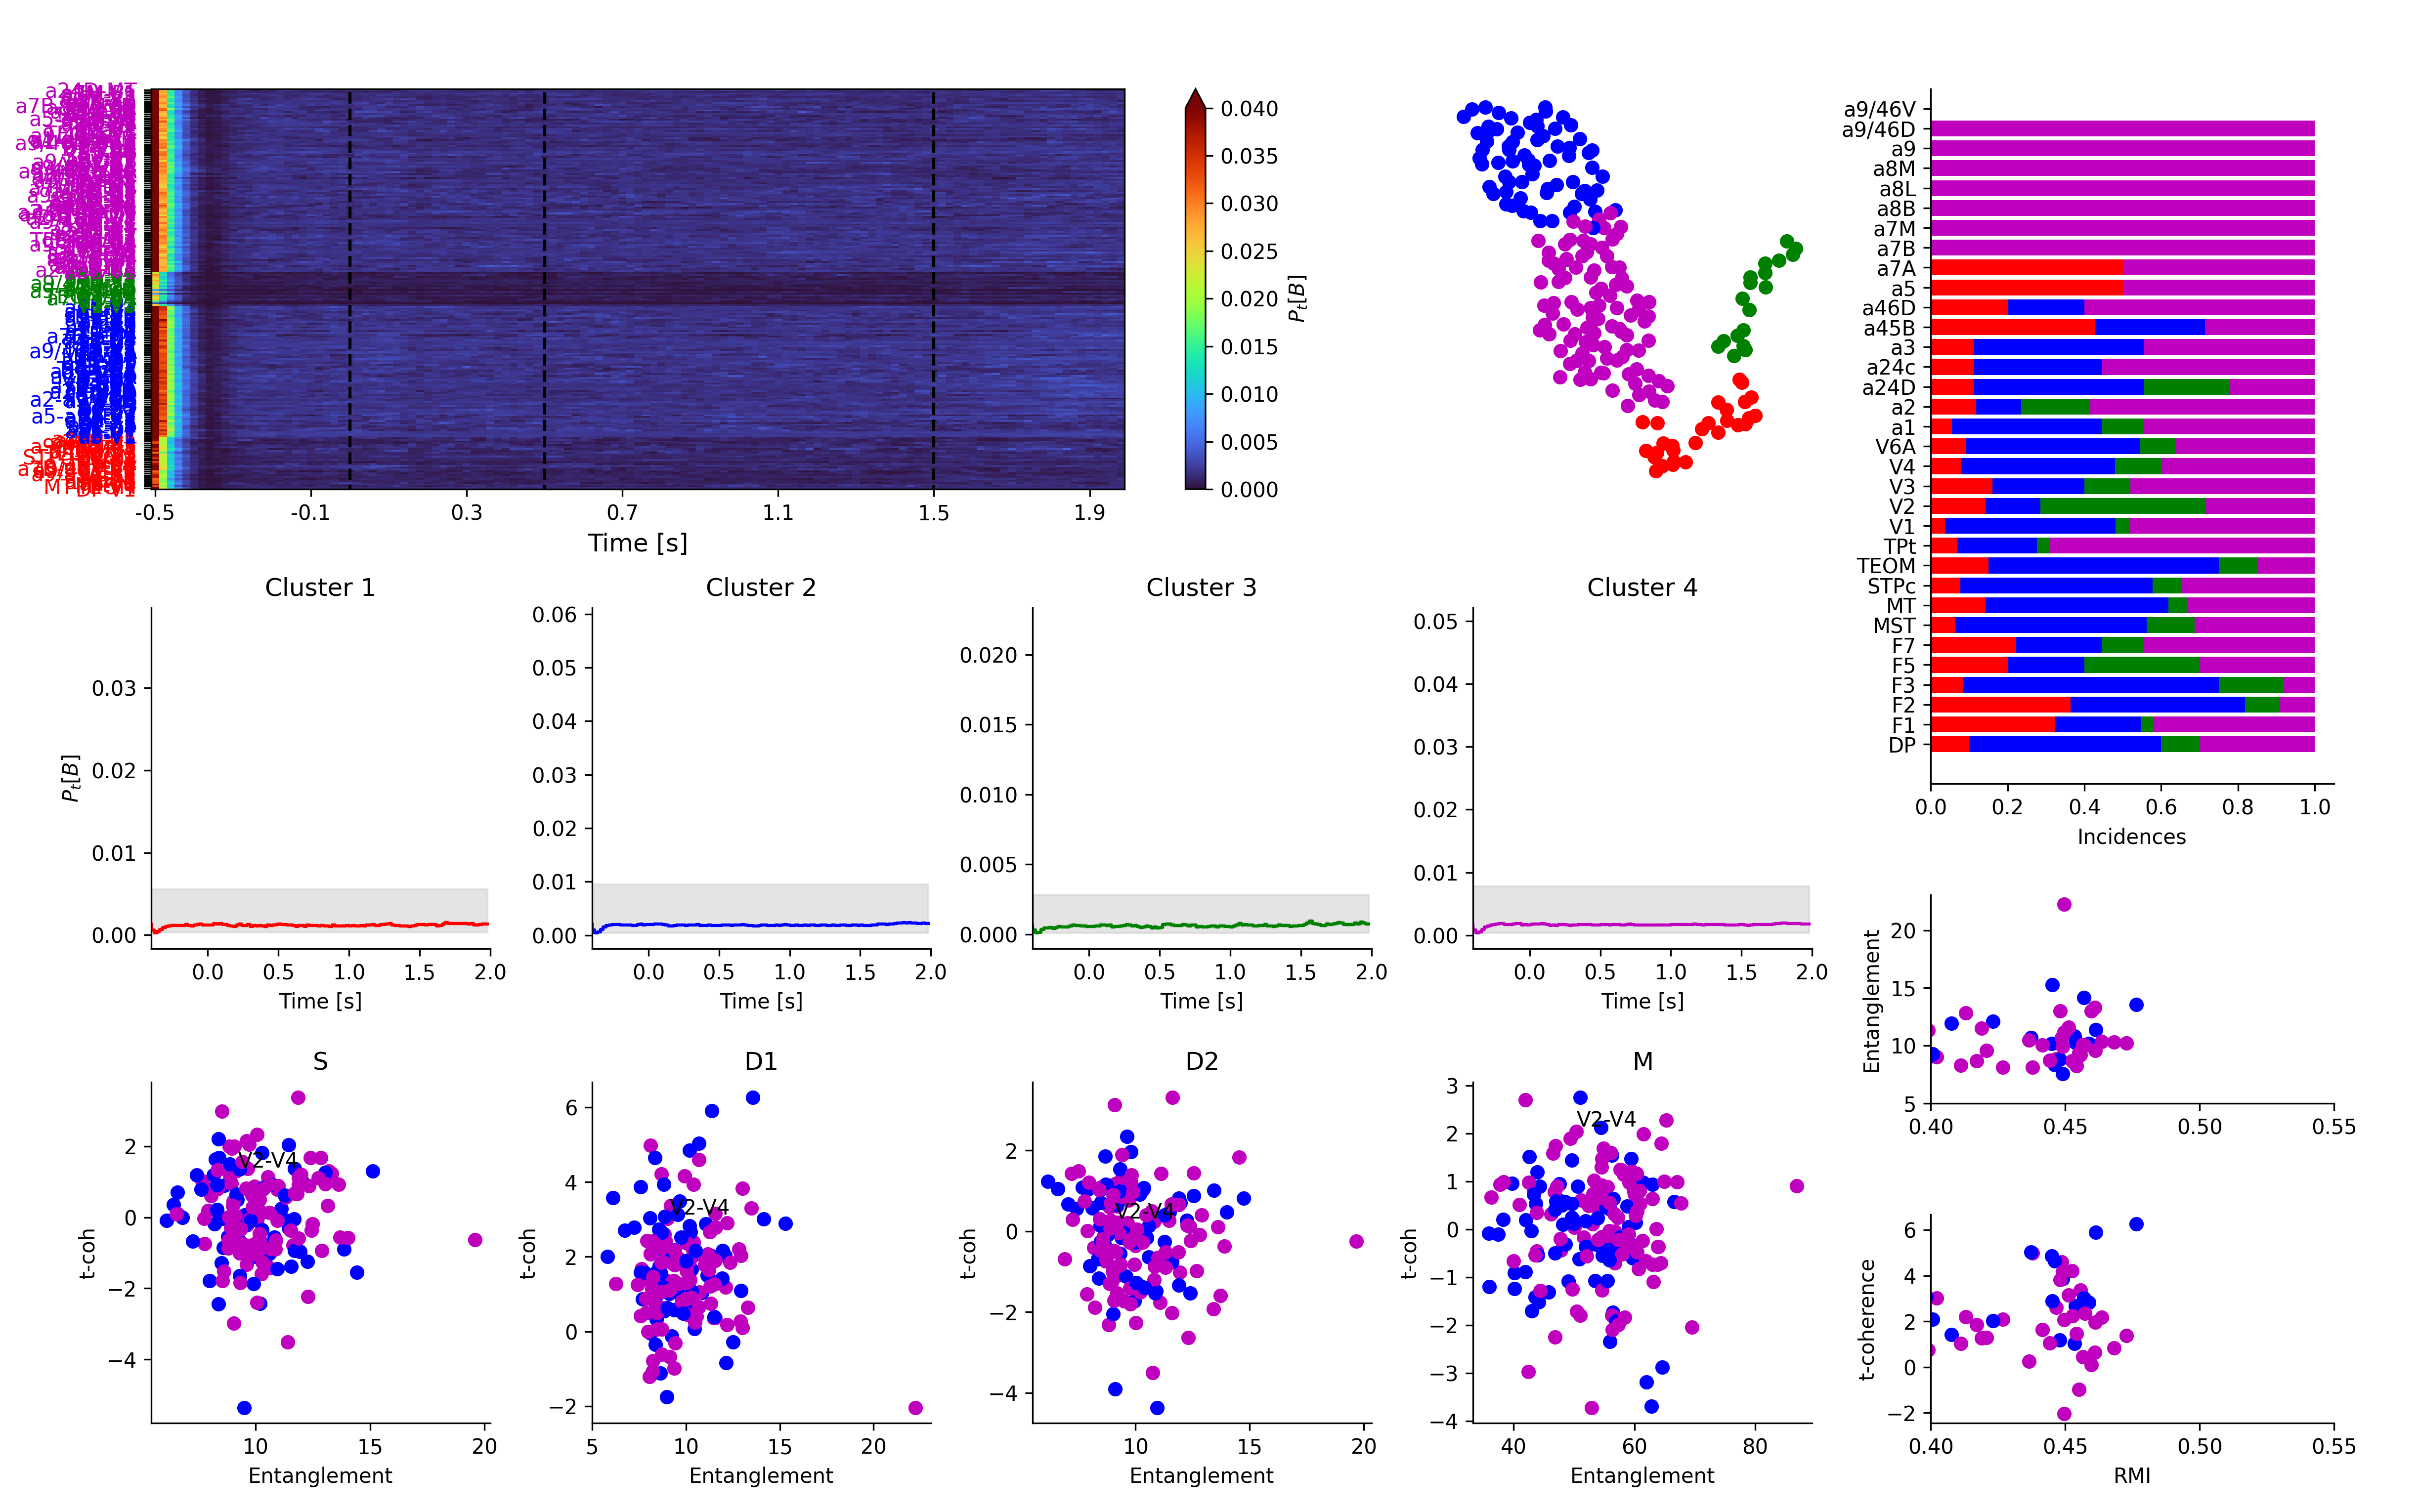

In [64]:
fig = plt.figure(figsize=(16, 10), dpi=300)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.05,
    right=0.75,
    wspace=0.1,
    bottom=0.68,
    top=0.95,
    width_ratios=(1.0, 0.3),
)

gs1 = fig.add_gridspec(
    nrows=1, ncols=4, left=0.05, right=0.75, wspace=0.3, bottom=0.37, top=0.6
)

gs2 = fig.add_gridspec(
    nrows=1, ncols=4, left=0.05, right=0.75, wspace=0.3, bottom=0.05, top=0.28
)

gs3 = fig.add_gridspec(
    nrows=3,
    ncols=1,
    left=0.8,
    right=0.97,
    wspace=0.5,
    hspace=0.3,
    bottom=0.05,
    top=0.95,
    height_ratios=(1.0, 0.3, 0.3),
)

# Panel A
ax1 = plt.subplot(gs0[0])
plot_rate_probability(ax1, vmax=0.04)
ax2 = plt.subplot(gs0[1])
plot_embedding(ax2, names=False)

# Panel B
ax3 = plt.subplot(gs1[0])
plot_rate(ax3, 0, colors[0])
plt.xlim(-0.4, 2)
plt.title("Cluster 1")
ax4 = plt.subplot(gs1[1])
plot_rate(ax4, 1, colors[1])
plt.xlim(-0.4, 2)
plt.ylabel("")
plt.title("Cluster 2")
ax5 = plt.subplot(gs1[2])
plot_rate(ax5, 2, colors[2])
plt.xlim(-0.4, 2)
plt.ylabel("")
plt.title("Cluster 3")
ax6 = plt.subplot(gs1[3])
plot_rate(ax6, 3, colors[3])
plt.xlim(-0.4, 2)
plt.ylabel("")
plt.title("Cluster 4")

# Panel C
ax7 = plt.subplot(gs2[0])
plot_ent_tcoh(ax7, 1)
ax8 = plt.subplot(gs2[1])
plot_ent_tcoh(ax8, 2)
ax9 = plt.subplot(gs2[2])
plot_ent_tcoh(ax9, 3)
ax10 = plt.subplot(gs2[3])
plot_ent_tcoh(ax10, 4)

# Panel D
ax11 = plt.subplot(gs3[0])
plt.sca(ax11)
x_ticks = range(data.sizes["roi"])
for i in [3, 2, 1, 0]:
    plt.barh(x_ticks, data[:, i] + data[:, :i].sum("cluster"), color=colors[i])
plt.yticks(x_ticks, data.roi.data)
plt.xlabel("Incidences")
[ax11.spines[key].set_visible(False) for key in ["top", "right"]]
ax12 = plt.subplot(gs3[1])
plot_rmi_tcoh(ax12, 2, ent)
plt.ylabel("Entanglement")
plt.xlim(0.4, 0.55)
ax13 = plt.subplot(gs3[2])
plot_rmi_tcoh(ax13, 2, t_coh_rois)
plt.ylabel("t-coherence")
plt.xlabel("RMI")
plt.xlim(0.4, 0.55)

bg = plot.Background(visible=False)
plt.savefig(f"img/panel_coh_rates_{monkey}.png")